# Population Map

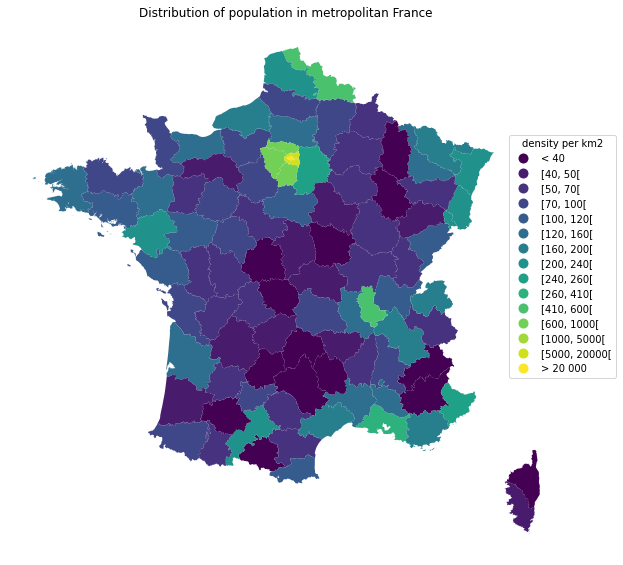

In [7]:
from pynsee.local import get_map
from pynsee.macro import *
import geopandas as gpd
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes

map_file = get_map('departements')
map = gpd.read_file(map_file)

dataset_list = get_dataset_list()

id = get_idbank_list("TCRED-ESTIMATIONS-POPULATION") 

id = id.loc[(id.AGE == "00-") &
            (id.SEXE == "0") &
            (id.REF_AREA.str.match("^D"))]

data = get_insee_idbank(id.idbank, lastNObservations=1)
data = data[['REF_AREA', 'OBS_VALUE']]

map['REF_AREA'] = 'D' + map['code']

map = map.to_crs(epsg=3035)
map["area"] = map['geometry'].area/ 10**6
map = map.to_crs(epsg=4326)

map = map.merge(data, how = 'left', on = 'REF_AREA')
map['density'] = map['OBS_VALUE'] / map["area"]

map.loc[map.density < 40, 'range'] = "< 40"
map.loc[map.density >= 20000, 'range'] = "> 20 000"

density_ranges = [40, 50, 70, 100, 120, 160, 200, 240, 260, 410, 600, 1000, 5000, 20000]
list_ranges = []
list_ranges.append( "< 40")

for i in range(len(density_ranges)-1):
    min = density_ranges[i]
    max = density_ranges[i+1]
    range_string = "[{}, {}[".format(min, max)
    map.loc[(map.density >= min) & (map.density < max), 'range'] = range_string
    list_ranges.append(range_string)

list_ranges.append("> 20 000")

map['range'] = map['range'].astype( CategoricalDtype(categories=list_ranges, ordered=True))

fig, ax = plt.subplots(1,1,figsize=[10,10])
map.plot(column='range', cmap=cm.viridis, 
    legend=True, ax=ax,
    legend_kwds={'bbox_to_anchor': (1.1, 0.8),
                 'title':'density per km2'})
ax.set_axis_off()
ax.set(title='Distribution of population in metropolitan France')
plt.show()
